In [22]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.0.0+cu117

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [23]:
# Load the graph data from a file
import pickle

project_name = "jfreechart"
#project_name = "argouml"
output_graph_data_file = "output/" + project_name + "/graph_data_for_problematic_classes.pickle"
with open(output_graph_data_file, 'rb') as file:
    G = pickle.load(file)

# Print nodes with their embedding
for node, embedding in G.nodes(data=True):
    print(f"Node: {node}, embedding: {embedding}")

Node: org.jfree.chart.entity.EntityCollection, embedding: {'CBO': 1.0, 'RFC': 8.0, 'SRFC': 0.0, 'DIT': 1.0, 'NOC': 1.0, 'WMC': 8.0, 'LOC': 9.0, 'CMLOC': 8.0, 'NOF': 0.0, 'NOSF': 0.0, 'NOM': 8.0, 'NOSM': 0.0, 'NORM': 0.0, 'LCOM': 0.0, 'LCAM': 0.7, 'LTCC': 0.0, 'ATFD': 0.0, 'SI': 0.0, 'Problematic': 0}
Node: org.jfree.data.statistics.DefaultStatisticalCategoryDataset, embedding: {'CBO': 4.0, 'RFC': 90.0, 'SRFC': 37.0, 'DIT': 2.0, 'NOC': 0.0, 'WMC': 86.0, 'LOC': 280.0, 'CMLOC': 264.0, 'NOF': 13.0, 'NOSF': 0.0, 'NOM': 30.0, 'NOSM': 0.0, 'NORM': 0.0, 'LCOM': 0.818, 'LCAM': 0.754, 'LTCC': 0.367, 'ATFD': 1.0, 'SI': 0.0, 'Problematic': 0}
Node: org.jfree.data.gantt.Task, embedding: {'CBO': 3.0, 'RFC': 25.0, 'SRFC': 10.0, 'DIT': 1.0, 'NOC': 0.0, 'WMC': 22.0, 'LOC': 66.0, 'CMLOC': 60.0, 'NOF': 4.0, 'NOSF': 1.0, 'NOM': 16.0, 'NOSM': 0.0, 'NORM': 0.0, 'LCOM': 0.717, 'LCAM': 0.806, 'LTCC': 0.65, 'ATFD': 0.0, 'SI': 0.0, 'Problematic': 0}
Node: org.jfree.chart.event.ChartProgress, embedding: {'CBO': 

In [24]:
import torch
from torch_geometric.data import Data

def networkx_to_pyg_data(graph):
    node_features_list = []
    labels = []
    node_mapping = {}
    node_index = 0

    for node, node_data in graph.nodes(data=True):
        node_mapping[node] = node_index
        features = [node_data['CBO'],
                    node_data['RFC'],
                    node_data['SRFC'],
                    node_data['DIT'],
                    node_data['NOC'],
                    node_data['WMC'],
                    node_data['LOC'],
                    node_data['CMLOC'],
                    node_data['NOF'],
                    node_data['NOSF'],
                    node_data['NOM'],
                    node_data['NOSM'],
                    node_data['NORM'],
                    node_data['LCOM'],
                    node_data['LCAM'],
                    node_data['LTCC'],
                    node_data['ATFD'],
                    node_data['SI']]
        node_features_list.append(features)
        labels.append(node_data['Problematic'])
        node_index += 1

    edge_index = []
    for source, target in graph.edges():
        edge_index.append([node_mapping[source], node_mapping[target]])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features_list, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

pyg_data = networkx_to_pyg_data(G)

In [25]:
def add_num_classes_to_pyg_data(data):
    num_classes = data.y.unique().size(0)
    data.num_classes = num_classes
    
add_num_classes_to_pyg_data(pyg_data)

print(f"Number of classes: {pyg_data.num_classes}")

Number of classes: 3


In [26]:
print(f'Dataset: {pyg_data}:')
print('======================')
print(f'Number of graphs: {len(pyg_data)}')
print(f'Number of features: {pyg_data.num_features}')
print(f'Number of classes: {pyg_data.num_classes}')
print(f'Number of nodes: {pyg_data.num_nodes}')
print(f'Number of edges: {pyg_data.num_edges}')
print(f'Average node degree: {pyg_data.num_edges / pyg_data.num_nodes:.2f}')
print(f'Has isolated nodes: {pyg_data.has_isolated_nodes()}')
print(f'Has self-loops: {pyg_data.has_self_loops()}')
print(f'Is undirected: {pyg_data.is_undirected()}')

Dataset: Data(x=[589, 18], edge_index=[2, 6357], y=[589], num_classes=3):
Number of graphs: 4
Number of features: 18
Number of classes: 3
Number of nodes: 589
Number of edges: 6357
Average node degree: 10.79
Has isolated nodes: False
Has self-loops: True
Is undirected: False


In [27]:
def save_pyg_dataset(dataset, file_path):
    torch.save(dataset, file_path)

# Assuming 'pyg_dataset' is the dataset you want to save
output_file_path = "output/" + project_name + "/pyg_dataset_for_problematic_class.pt"
save_pyg_dataset(pyg_data, output_file_path)

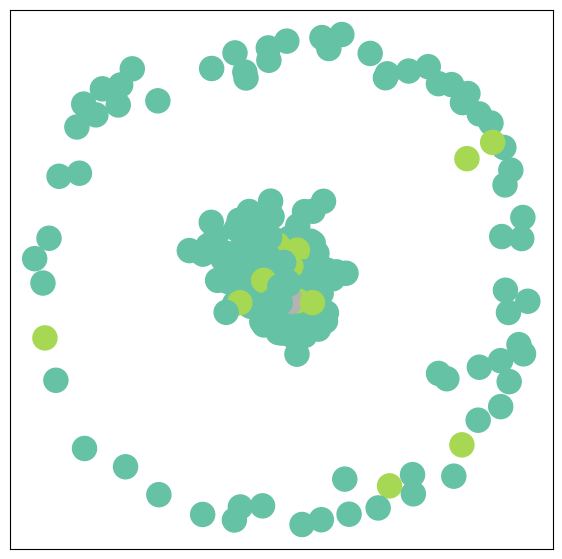

In [28]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

G = to_networkx(pyg_data, to_undirected=True)
visualize_graph(G, color=pyg_data.y)

In [31]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(pyg_data.num_features, 16)
        self.classifier = Linear(16, pyg_data.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(18, 16)
  (classifier): Linear(in_features=16, out_features=3, bias=True)
)


Embedding shape: [589, 16]


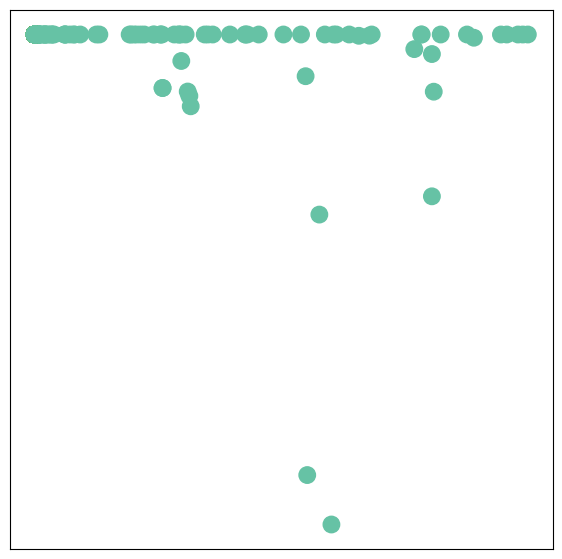

In [32]:
model = GCN()

_, h = model(pyg_data.x, pyg_data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

visualize_embedding(h, color=pyg_data.y)

In [33]:
import random

def add_train_mask_to_pyg_data(data, train_ratio=0.8):
    num_nodes = data.num_nodes
    num_train_nodes = int(train_ratio * num_nodes)

    # Generate a list of True and False values with the specified ratio
    mask_values = [True] * num_train_nodes + [False] * (num_nodes - num_train_nodes)

    # Randomly shuffle the mask values
    random.shuffle(mask_values)

    # Convert the mask_values list to a boolean tensor and assign it to the Data object
    data.train_mask = torch.tensor(mask_values, dtype=torch.bool)

# Example usage
add_train_mask_to_pyg_data(pyg_data, train_ratio=0.8)

print(f"Train mask: {pyg_data.train_mask}")


Train mask: tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True, False,  True, False,  True, False,  True, False, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
        False,  True, False,  True, False,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True, False,  True,  True,  True,  True, False,  True,  True,
        False, False,  True,  True,  True,  True, Fa

<IPython.core.display.Javascript object>

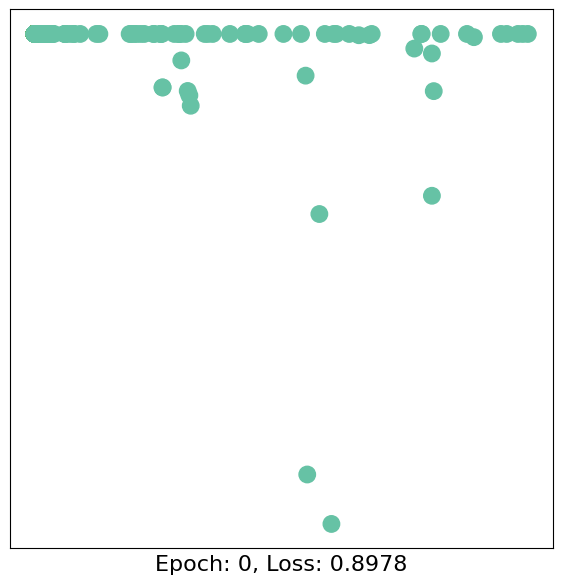

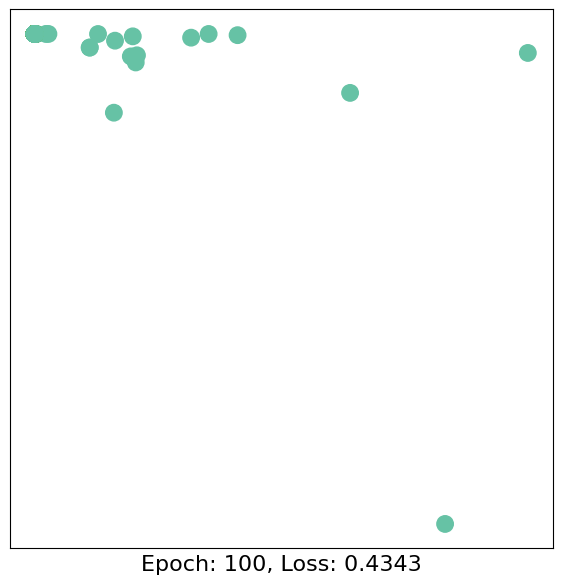

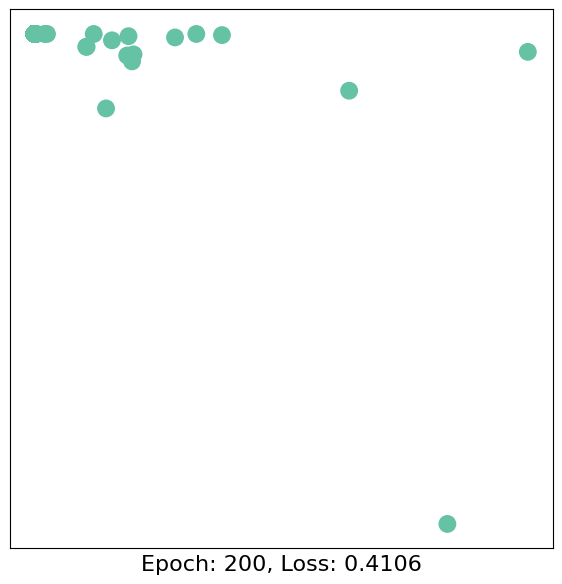

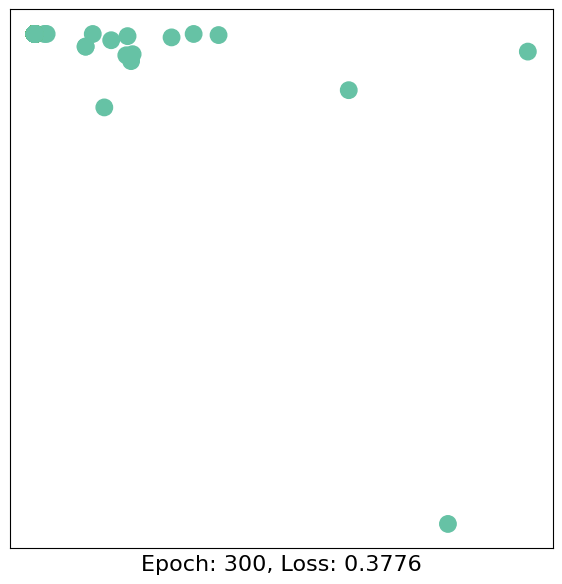

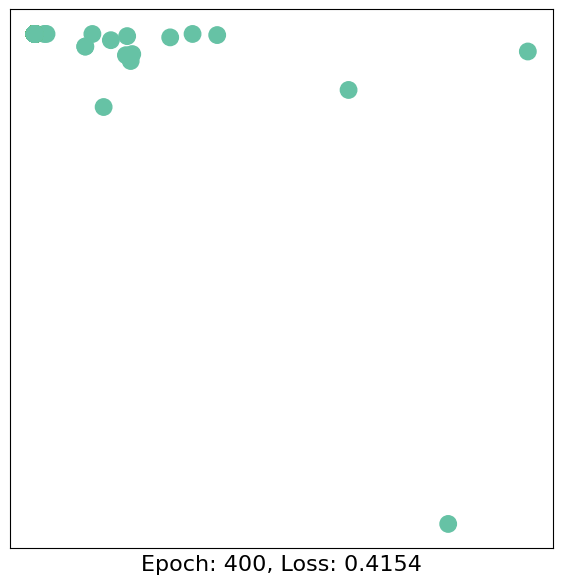

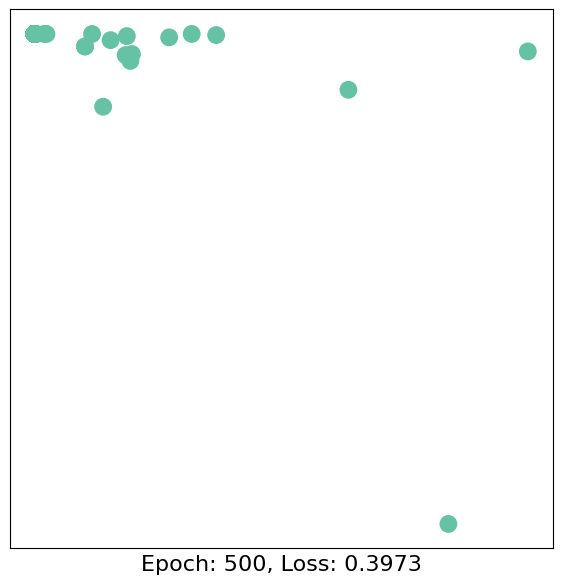

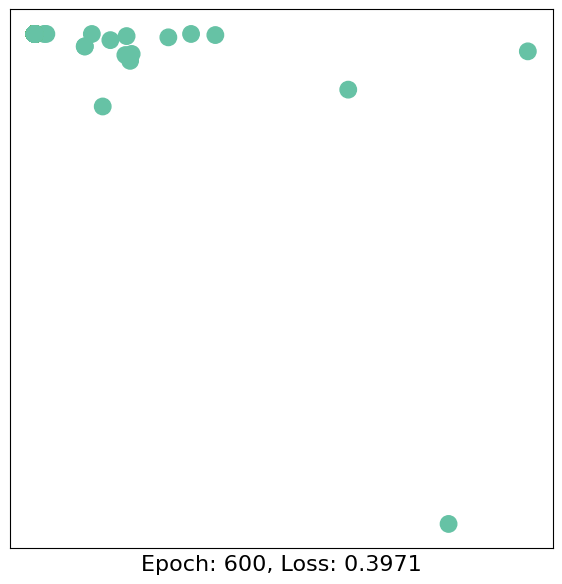

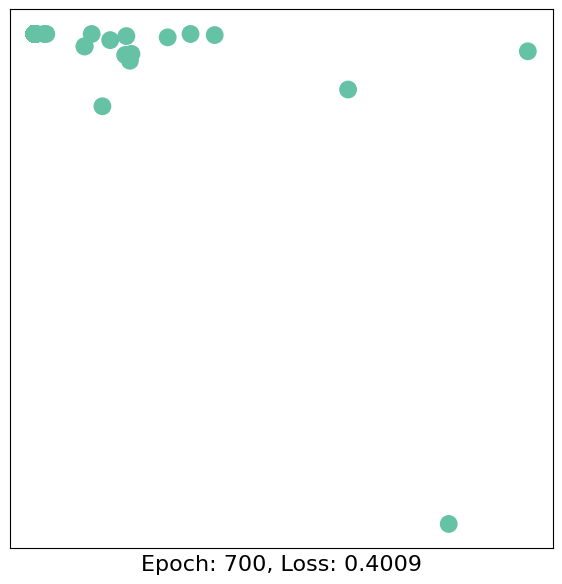

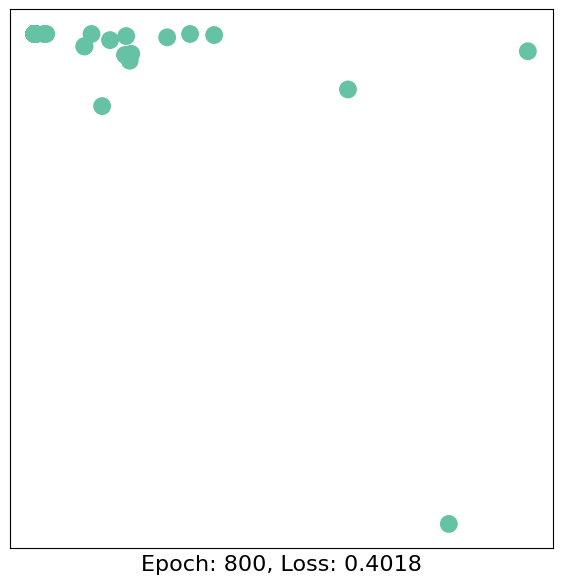

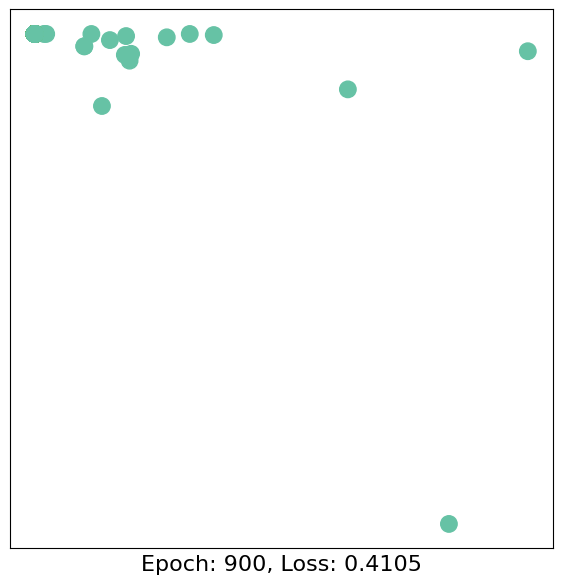

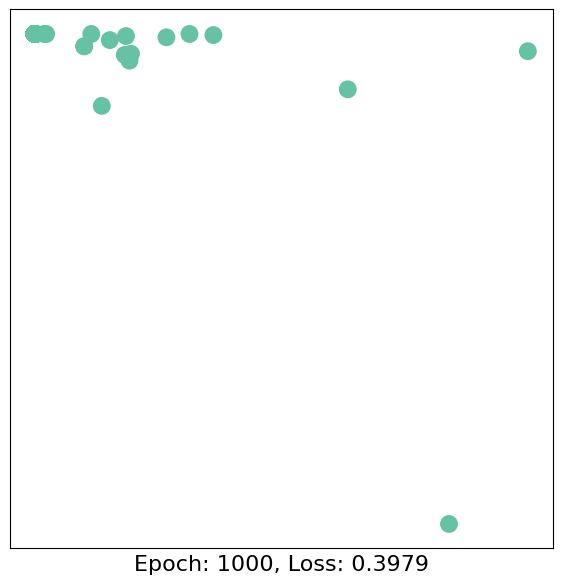

In [34]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(1001):
    loss, h = train(pyg_data)
    if epoch % 100 == 0:
        visualize_embedding(h, color=pyg_data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

In [35]:
def add_test_mask_to_pyg_data(data):
    # If the train_mask is not set, raise an exception
    if not hasattr(data, 'train_mask'):
        raise ValueError("Please add a train_mask to the Data object first.")
    
    # Create a test mask as the complement of the train mask
    data.test_mask = ~data.train_mask

add_test_mask_to_pyg_data(pyg_data)

print(f"Test mask: {pyg_data.test_mask}")

Test mask: tensor([False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True, False,  True, False,  True, False,  True,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,  True,
         True, False,  True, False,  True, False, False, False, False, False,
         True, False,  True, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False,  True, False, False,
         True,  True, False, False, False, False,  Tr

In [36]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index)

        # Convert logits to class labels
        pred_labels = pred[0].argmax(dim=1)

        correct = (pred_labels[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        print(f'Accuracy: {acc:.4f}')

# Example usage
evaluate(model, pyg_data)

Accuracy: 0.7966
